<a href="https://colab.research.google.com/github/Adeola23/Machine-learning/blob/main/NLP_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "ade0laa" # username from the json file
os.environ['KAGGLE_KEY'] = "b1c944b0f8f0dc2f5eee86dc65cadf79" # key from the json file
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification # api copied from kaggle

100% 4.38M/4.38M [00:00<00:00, 22.8MB/s]



In [2]:
!unzip covid-19-nlp-text-classification.zip

Archive:  covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn # import sklearn
import nltk # import nltk
from nltk.corpus import stopwords #import stop words
import re # import regular expression
from nltk.tokenize import word_tokenize # import word_tokenize
import matplotlib
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt #import matplotlib.pyplot 
from sklearn.feature_extraction.text import TfidfVectorizer #  import TF-idf vectorizer

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

In [5]:
train_df = pd.read_csv("/content/Corona_NLP_train.csv",  encoding='ISO-8859-1', parse_dates=['TweetAt'])
test_df = pd.read_csv("/content/Corona_NLP_test.csv",  encoding='ISO-8859-1', parse_dates=['TweetAt'])



In [6]:
df_t = pd.read_csv("/content/Corona_NLP_train.csv",  encoding='ISO-8859-1', parse_dates=['TweetAt'])

In [7]:
df_q = pd.read_csv("/content/Corona_NLP_test.csv",  encoding='ISO-8859-1', parse_dates=['TweetAt'])

In [8]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,2020-02-03,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [10]:
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [11]:
train_df.shape, test_df.shape

((41157, 6), (3798, 6))

In [12]:
# we combined the train_df and test_df into one dataframe for preprocessing

# Create new column to identify the test data
train_df['is_test'] = 0
test_df['is_test'] = 1

# combine 
comp_df = pd.concat([train_df, test_df])
comp_df.reset_index(drop=True, inplace=True)


In [13]:
# Have a look on the target features
comp_df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [14]:
comp_df['Sentiment'] = comp_df.Sentiment.str.replace('Extremely Positive', 'Positive')
comp_df['Sentiment'] = comp_df.Sentiment.str.replace('Extremely Negative', 'Negative')

Text(0, 0.5, 'Sentiment')

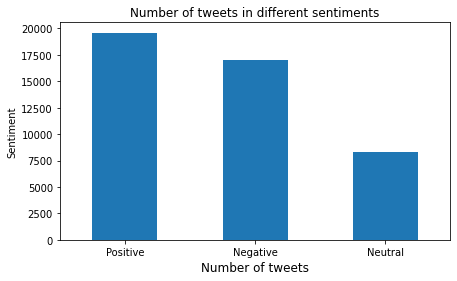

In [15]:
comp_df.Sentiment.value_counts().plot.bar(figsize=(7,4))
plt.xticks(rotation=None)
plt.title('Number of tweets in different sentiments',fontsize=12)
plt.xlabel('Number of tweets', fontsize=12)
plt.ylabel('Sentiment')

In [16]:
# Map the sentiment into 0 , 1, 2
comp_df['Sentiment'] = comp_df['Sentiment'].map({'Positive':2, 'Negative':0, 'Neutral':1})

In [17]:
comp_df['month'] = comp_df['TweetAt'].dt.month

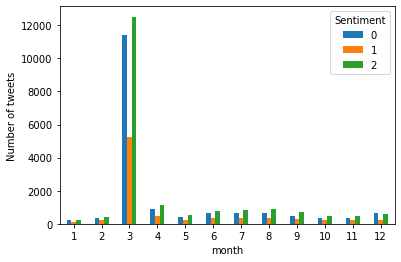

In [18]:
# Visual the date with the labels
pd.crosstab(comp_df.month, comp_df.Sentiment).plot.bar()
plt.ylabel('Number of tweets')
plt.xticks(rotation=None)
plt.show()

In [19]:
HQ_words = ' '.join([i for i in df_t['OriginalTweet']]).split() 
unigram_HQ = pd.Series(nltk.ngrams(HQ_words, 1)).value_counts()[:15]
unigram_HQ = pd.DataFrame(unigram_HQ)
unigram_HQ['idx'] = unigram_HQ.index
unigram_HQ['idx'] = unigram_HQ.apply(lambda x: '('+x['idx'][0]+')',axis=1)

In [20]:
import plotly.graph_objs as go
import plotly.offline as pyoff

plot_data = [
    go.Bar(
        x=unigram_HQ['idx'],
        y=unigram_HQ[0],
        marker = dict(
            color = 'Blue'
        )
    )
]
plot_layout = go.Layout(
        title='Top 15 uni-grams from Covid-19 Tweets',
        yaxis_title='Count',
        xaxis_title='Uni-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [21]:
bigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 2)).value_counts())[:15]
bigram_HQ = pd.DataFrame(bigram_HQ)
bigram_HQ['idx'] = bigram_HQ.index
bigram_HQ['idx'] = bigram_HQ.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+')',axis=1)

In [22]:
plot_data = [
    go.Bar(
        x=bigram_HQ['idx'],
        y=bigram_HQ[0],
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 15 bi-grams from Covid 19 Tweets',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [23]:
trigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 3)).value_counts())[:20]
trigram_HQ = pd.DataFrame(trigram_HQ)
trigram_HQ['idx'] = trigram_HQ.index
trigram_HQ['idx'] = trigram_HQ.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+', '+x['idx'][2]+')',axis=1)


In [24]:
plot_data = [
    go.Bar(
        x=trigram_HQ['idx'],
        y=trigram_HQ[0],
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 15 Tri-grams from Covid 19 Tweets',
        yaxis_title='Count',
        xaxis_title='Tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [25]:
# In this task we will focus on the text data only, so we drop the other columns
comp_df = comp_df[['OriginalTweet','Sentiment','is_test']]

In [26]:
comp_df['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [27]:
#The elements we would like to remove from the tweet's content
#URL
#punctuations
#tags
#@ tags
#extra space

# Change columns name for easy access
comp_df.columns =['tweet','label','is_test']

In [28]:
#Remove @ tags
comp_df.tweet = comp_df.tweet.str.replace(r'(@\w*)','')

#Remove URL
comp_df.tweet = comp_df.tweet.str.replace(r"http\S+", "")

#Remove # tag
comp_df.tweet = comp_df.tweet.str.replace(r'#\w+',"")

#Remove all non-character
comp_df.tweet = comp_df.tweet.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
comp_df.tweet = comp_df.tweet.str.replace(r'( +)'," ")
comp_df.tweet = comp_df.tweet.str.strip()

# Change to lowercase
comp_df.tweet = comp_df.tweet.str.lower()

In [29]:
comp_df.tweet[0]

'and and'

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [32]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
# Create new columns for storing
comp_df['corpus'] = [nltk.word_tokenize(text) for text in comp_df.tweet]
lemma = nltk.WordNetLemmatizer()
comp_df.corpus = comp_df.apply(lambda x: [lemma.lemmatize(word) for word in x.corpus], axis=1)
comp_df.corpus = comp_df.apply(lambda x: " ".join(x.corpus),axis=1)

In [34]:
stop_words = stopwords.words('english')

In [35]:
text = comp_df.corpus.values
wordcloud = WordCloud(max_words=500,background_color='black', stopwords=stop_words, colormap='rainbow',height=300)
wordcloud.generate(str(text))

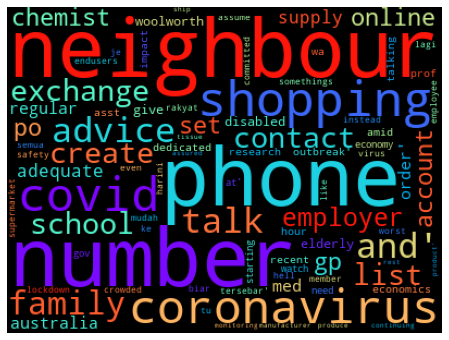

In [36]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(15)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [37]:
# Import the tools we need
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

In [38]:
# Split the data back to train and test set
train_df = comp_df[comp_df.is_test==0]
test_df = comp_df[comp_df.is_test==1]
train_df.drop('is_test',axis=1, inplace=True)
test_df.drop('is_test',axis=1, inplace=True)
test_df.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:

x_df = train_df.corpus
y_df = train_df['label']

x_test = test_df.corpus
y_test =test_df['label']

# Split to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_df,y_df, test_size=0.2,random_state=42)

In [40]:
# Check the shape
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((32925,), (8232,), (32925,), (8232,))

In [41]:
# Create the vectorizer
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(comp_df.corpus)

# transform both train and valid data
x_train_vector = vectorizer.transform(x_train)
x_val_vector = vectorizer.transform(x_val)

In [42]:
cross_val_score(LogisticRegression(random_state=42), x_train_vector, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.3s finished


0.793986553826206

In [43]:
#params = {
    #'solver':['liblinear','saga','newton-cg','lbfgs'],
    #'C':[0.001,0.01,0.1,1,10,100],
    #'penalty':['l1','l2']
#}

#lr_grid = GridSearchCV(LogisticRegression(random_state=42),params, cv=5, verbose=2, n_jobs=-1)
#lr_grid.fit(x_train_vector, y_train)

#nprint(classification_report(y_val, lr_grid.predict(x_val_vector)))

In [44]:
#To skip the training time on kaggle, I use the best parameter found in my notebook directly
best_model = LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')
best_model.fit(x_train_vector, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
print(classification_report(y_val, best_model.predict(x_val_vector)))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      3062
           1       0.73      0.80      0.76      1553
           2       0.86      0.85      0.86      3617

    accuracy                           0.83      8232
   macro avg       0.81      0.82      0.81      8232
weighted avg       0.83      0.83      0.83      8232



In [46]:
x_test_tf = vectorizer.transform(x_test)

In [47]:
y_pred = best_model.predict(x_test_tf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1633
           1       0.68      0.74      0.71       619
           2       0.81      0.83      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.78      0.78      3798
weighted avg       0.80      0.79      0.79      3798



In [48]:
df_t.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [49]:
df_t = df_t[['OriginalTweet','Sentiment']]

In [50]:
df_t.columns = ['tweet', 'label']

In [51]:
df_t.head()

,tweet,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [52]:
df_t['label'] = df_t.label.str.replace('Extremely Positive', 'Positive')
df_t['label'] = df_t.label.str.replace('Extremely Negative', 'Negative')

In [53]:
df_t['label'] = df_t['label'].map({'Positive':2, 'Negative':0, 'Neutral':1})

In [54]:
df_x, df_y = df_t['tweet'].copy(), df_t['label'].copy()
df_x.head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: tweet, dtype: object

In [55]:
#Remove @ tags
df_x = df_x.str.replace(r'(@\w*)','')

#Remove URL
df_x = df_x.str.replace(r"http\S+", "")

#Remove # tag
df_x = df_x.str.replace(r'#\w+',"")

#Remove all non-character
df_x = df_x.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
df_x = df_x.str.replace(r'( +)'," ")
df_x = df_x.str.strip()

# Change to lowercase
df_x = df_x.str.lower()

In [56]:
df_x[0]

'and and'

In [57]:
df_y.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_x)
vocab_size = len(tokenizer.word_index) + 1
print('vocabulary size:{}'.format(vocab_size))

max_len = max(df_x.apply(len))
print('max length of input:{}'.format(max_len))

sequence = tokenizer.texts_to_sequences(df_x)

x = pad_sequences(sequence, max_len, padding='post')
print('example x:{}'.format(x[4]))

vocabulary size:42089
max length of input:286
example x:[   86   717     2    73    15    20    52     1 18163    99   111  3842
    46    99    36    17    84     8 18164   217     1     8     5   805
   294    46    93    89    66    27  1603   431     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0  

In [59]:
BATCH_SIZE = 64
EPOCHS = 4
embedding_dim=16
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.GlobalMaxPool1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='sigmoid')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 286, 16)           673424    
_________________________________________________________________
bidirectional (Bidirectional (None, 286, 512)          420864    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,127,315
Trainable params: 1,127,315
Non-trainable params: 0
______________________________________________

In [60]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, df_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/4
579/579 [==============================] - 99s 155ms/step - loss: 0.9287 - accuracy: 0.5455 - val_loss: 0.4145 - val_accuracy: 0.8545
Epoch 2/4
579/579 [==============================] - 88s 152ms/step - loss: 0.3568 - accuracy: 0.8810 - val_loss: 0.3375 - val_accuracy: 0.8863
Epoch 3/4
579/579 [==============================] - 89s 154ms/step - loss: 0.1975 - accuracy: 0.9381 - val_loss: 0.4020 - val_accuracy: 0.8768
Epoch 4/4
579/579 [==============================] - 88s 153ms/step - loss: 0.1215 - accuracy: 0.9599 - val_loss: 0.4517 - val_accuracy: 0.8707


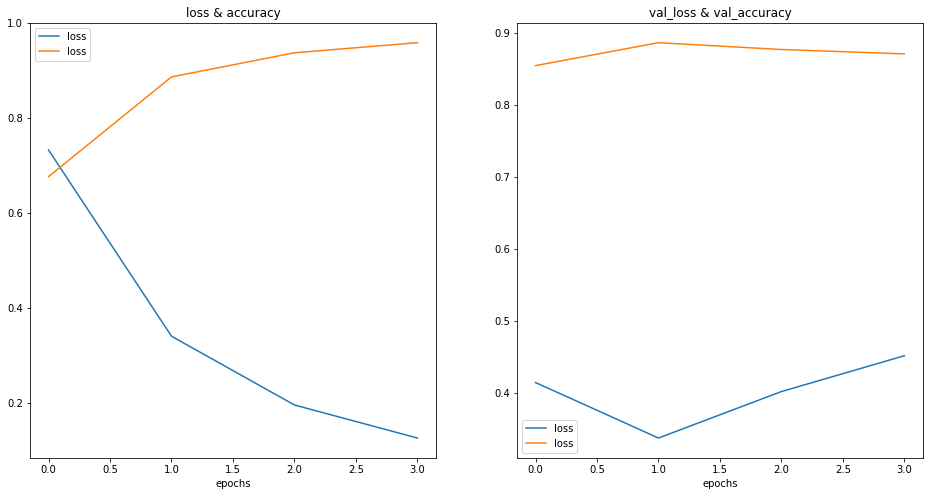

In [61]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

_, axis = plt.subplots(1,2, figsize=(16,8))
axis[0].plot(range(EPOCHS), loss, label='loss')
axis[0].plot(range(EPOCHS), acc, label='loss')
axis[1].plot(range(EPOCHS), val_loss, label='loss')
axis[1].plot(range(EPOCHS), val_acc, label='loss')
axis[0].legend()
axis[1].legend()
axis[0].set_title('loss & accuracy')
axis[0].set_xlabel('epochs')

axis[1].set_title('val_loss & val_accuracy')
axis[1].set_xlabel('epochs')

plt.show()


In [62]:
test_x = df_q['OriginalTweet'].copy()
test_y = df_q['Sentiment'].copy()



In [63]:
#Remove @ tags
test_x = test_x.str.replace(r'(@\w*)','')

#Remove URL
test_x = test_x.str.replace(r"http\S+", "")

#Remove # tag
test_x = test_x.str.replace(r'#\w+',"")

#Remove all non-character
test_x = test_x.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
test_x = test_x.str.replace(r'( +)'," ")
test_x = test_x.str.strip()

# Change to lowercase
test_x = test_x.str.lower()

In [64]:
test_x[0]

'trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as fearing shoppers stock up'

In [65]:
test_x = tokenizer.texts_to_sequences(test_x)

In [66]:
test_x = pad_sequences(test_x, max_len, padding='post')

In [67]:
test_y.head()

0    Extremely Negative
1              Positive
2    Extremely Positive
3              Negative
4               Neutral
Name: Sentiment, dtype: object

In [68]:
test_y = test_y.str.replace('Extremely Positive', 'Positive')
test_y = test_y.str.replace('Extremely Negative', 'Negative')

In [69]:
test_y = test_y.map({'Positive':2, 'Negative':0, 'Neutral':1})

In [70]:
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

[0 2 2 ... 1 0 2]


Accuracy: 0.8725645076355977


Text(25.5, 0.5, 'True Value')

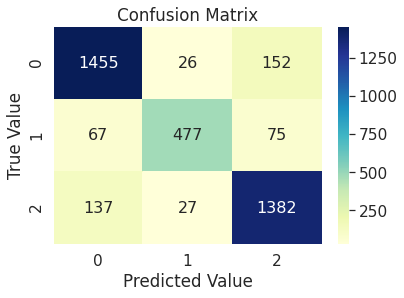

In [71]:
cm = confusion_matrix(test_y, y_pred)
cm_df = pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(test_y, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")